# Surface water mapping using Sentinle-1 backscatter



This notebook gives an example of using Sentinel-1 backscatter to map surface water extent. 

Following steps are demonstrated:
1. [Load Sentinel-1 data through the datacube API](#load)
2. [Apply speckle filtering to the data](#speckle)
3. [Visualize backscatter distributions](#visual)
4. [Use threshold values to separate water and non-water pixels](#thresholding)
5. [Calculate water detection frequencies and compare to optical detections](#summary)

In a nutshell, backscatter distributions are inspected and optimal feature and thresholds are selected to classify water. Caveats of the method include manual tuning of parameters and failure to map water in windy conditions.

The code below makes use of the datacube API and requires that:
* Sentinel-1 backscatter for VV and VH polarizations are processed using SNAP.
* Data are indexed as product 's1_gamma0_scene_v2' in a datacube database that's configured in radar.con


## 1. Load Sentinel-1 data through the datacube API  <a name="load"></a>

Area of interest is Lake George, an endorheic lake in south-eastern New South Wales, Australia.

In [1]:
%matplotlib inline
import numpy as np
import datacube

In [2]:
dc = datacube.Datacube(config='radar.conf')

In [3]:
# Define area and time period of interest

query = {
'y': (-35.217575569215505, -34.97543887925878), 
'x': (149.2719268798828, 149.5095062255859),
'time':('2017-09-01','2017-12-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}

In [4]:
radar = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', **query)

In [5]:
# select scenes covering at least 50% of the area
total_px=len(radar.x)*len(radar.y)
valid=radar.where(radar.vv!=0).where(radar.vh!=0).count(dim=('x','y'))
good=(valid.vh/total_px)>0.5
radar = radar.sel(time=good)

In [6]:
# replace 0 with nan
radar = radar.where(radar!=0)

In [7]:
radar

<xarray.Dataset>
Dimensions:  (time: 7, x: 1003, y: 1185)
Coordinates:
  * time     (time) datetime64[ns] 2017-09-05T19:15:50.607985 ... 2017-11-28T19:15:51.133110
  * y        (y) float64 -3.955e+06 -3.955e+06 ... -3.926e+06 -3.926e+06
  * x        (x) float64 1.589e+06 1.589e+06 1.589e+06 ... 1.564e+06 1.564e+06
Data variables:
    vh       (time, y, x) float32 0.048105452 0.023859339 ... 0.00062273693
    vv       (time, y, x) float32 0.22519502 0.09242475 ... 0.04959599
Attributes:
    crs:      EPSG: 3577

## 2. Apply speckle filtering to the data <a name="speckle"></a>

With options to remove/reduce negative and extremely high backscatter values.

In [8]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

In [9]:
from scipy.ndimage import grey_dilation, grey_erosion
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.morphology import disk

def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    Option to fill negative pixel with grey_dilation
    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output


def denoise(ds, verbose = False, bands = None, fill_negative = True, remove_high = False):
    """
    Apply lee filter to a S1 dataset loaded from datacube.
    Keep nodata pixels as lee filter implemnation doesn't consider nan
    """
    if not bands: bands = list(ds.data_vars)    
    # save the nodata mask
    zero_mask = (ds==0).to_array().any(axis=0)
    nan_mask = (np.isnan(ds)).to_array().any(axis=0)
    nodata_mask = zero_mask | nan_mask
    ds = ds.where(~nodata_mask, 0)
    smoothed = ds[bands[0]].groupby('time').apply(lee_filter, size=7).to_dataset(name=bands[0])
    for band in bands[1:]: smoothed[band] = ds[band].groupby('time').apply(lee_filter, size=7)
        
    if fill_negative:
        # reduce impact of negative pixels
        for band in bands:
            dilated = smoothed[band].groupby('time').apply(grey_dilation, footprint=disk(3))
            smoothed[band] = smoothed[band].where(smoothed[band] > 0, dilated)

    if verbose:
        for band in bands: print("# of negative pixels in %s:"%band, (smoothed[band]<0).sum().values)

    if remove_high:
        # reduce extreme outliers 
        for band in bands:
            eroded = smoothed[band].groupby('time').apply(grey_erosion, size=(3,3))
            smoothed[band] = smoothed[band].where(smoothed[band] < eroded.max(), eroded)

    return smoothed.where(~nodata_mask)


In [10]:
clean = denoise(radar)

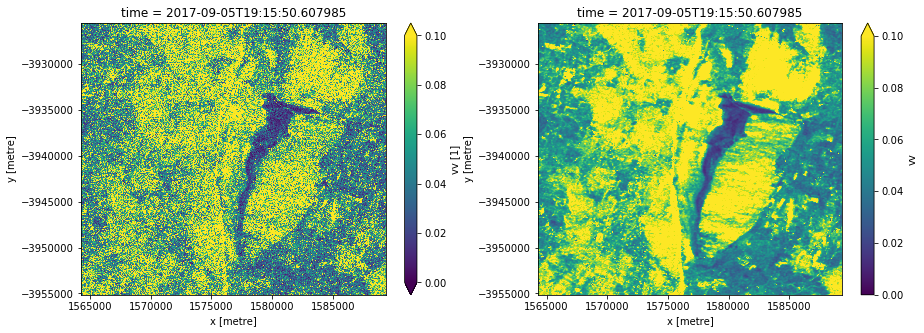

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# speckled image before filtering
radar.isel(time=0).vv.plot(vmin=0,vmax=0.1, ax = ax[0])
# filtered
clean.isel(time=0).vv.plot(vmin=0,vmax=0.1, ax = ax[1])

In [12]:
# alternative quick mean filter
smoothed_mean = radar.rolling(x=7).mean().rolling(y=7).mean()

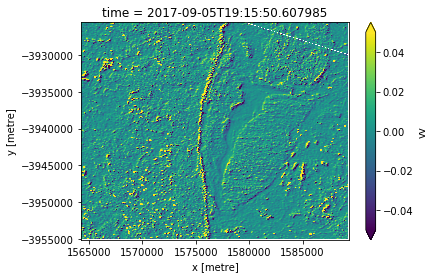

In [13]:
# visible difference on edge of features and for narrow features
(smoothed_mean.isel(time=0).vv-clean.isel(time=0).vv).plot(vmin=-0.05, vmax=0.05)

## 3. Visualize backscatter distributions <a name="visual"></a>

In [14]:
# vh_over_vv is a poentially useful third feature (after vv and vh)
clean['vh_over_vv']=clean.vh/clean.vv

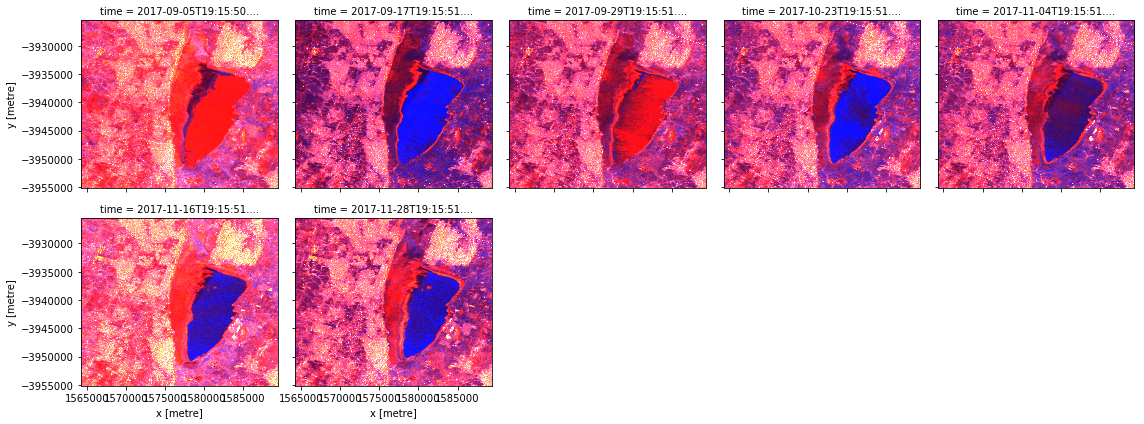

In [15]:
clean['vh_over_vv_scaled']=clean['vh_over_vv']/10. # scaled to have comparable range with vv and vh.
clean[['vv','vh','vh_over_vv_scaled']].to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=0.05)

In [16]:
from astropy.stats import histogram

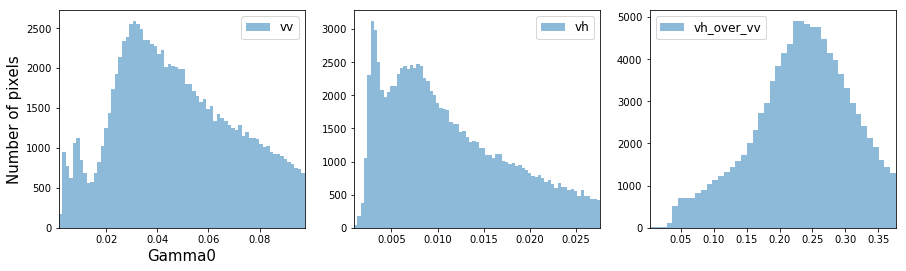

In [17]:
# In this area, VV gives best separation in general

f, axes =plt.subplots(1, 3, figsize=(15,4))

for i, band in enumerate(['vv','vh','vh_over_vv']):

    test = clean[band].values.ravel()
    test = test[~np.isnan(test)]
    test = test[test < np.percentile(test, 90)]
    h, b = histogram(np.random.choice(test, 100000), bins='knuth')
    axes[i].bar(b[:-1],h,width=b[1]-b[0], align='edge', alpha=0.5,label=band);
    axes[i].set_xlim((b[0], b[-1]));
    axes[i].legend(fontsize=12);

axes[0].set_xlabel('Gamma0',size=15);
axes[0].set_ylabel('Number of pixels',size=15);

## 4. Use threshold values to separate water and non-water pixels <a name="thresholding"></a>

In [18]:
from scipy.signal import argrelextrema


def find_optimal_minimum(hist, hist_x, min_valid=0.001, max_valid=0.03, min_contrast=1.2, min_perc= 0.01, 
                         verbose=False):
    minima= hist_x[argrelextrema(hist, np.less, order=1)]
    maxima= hist_x[argrelextrema(hist, np.greater, order=1)]
    # no minima or maxima found
    if len(minima)==0 or len(maxima)==0: 
        if verbose: print('no minima or maxima')
        return None
    # minima not in approprite range
    if minima.max() < min_valid or minima.min() > max_valid: 
        if verbose: print('minima outside valid range')
        return None
    minima=minima[minima>=min_valid]
    minima=minima[minima<=max_valid]
    # find minimum with largest contrast
    contrast=0
    best_m=None
    hist_maxima=hist[argrelextrema(hist, np.greater, order= 1)]
    for m in minima:
        # has to have a maximum on lower side
        lower_peaks=hist_maxima[maxima<m]
        if len(lower_peaks)==0: continue
        # has to have more than min_perc below threshold
        # note the histograms don't extend full range of values, so 0.1 means much less than 10% overall
        # this can potentially be constrained from minimum extent from wofs
        if hist[:np.where(hist_x==m)[0][0]+1].sum()/hist.sum()<min_perc: continue
        low=hist[np.where(hist_x==m)[0]][0]    
        this_contrast=lower_peaks.max()/low
        if this_contrast>contrast:
            contrast=this_contrast
            best_m=m
    if best_m is None or contrast<min_contrast: 
        if verbose: print('Minimum percent or minimum contrast is not met.')
        return None
    return hist_x[np.where(hist_x==best_m)[0]+1][0]  # right boundary


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-

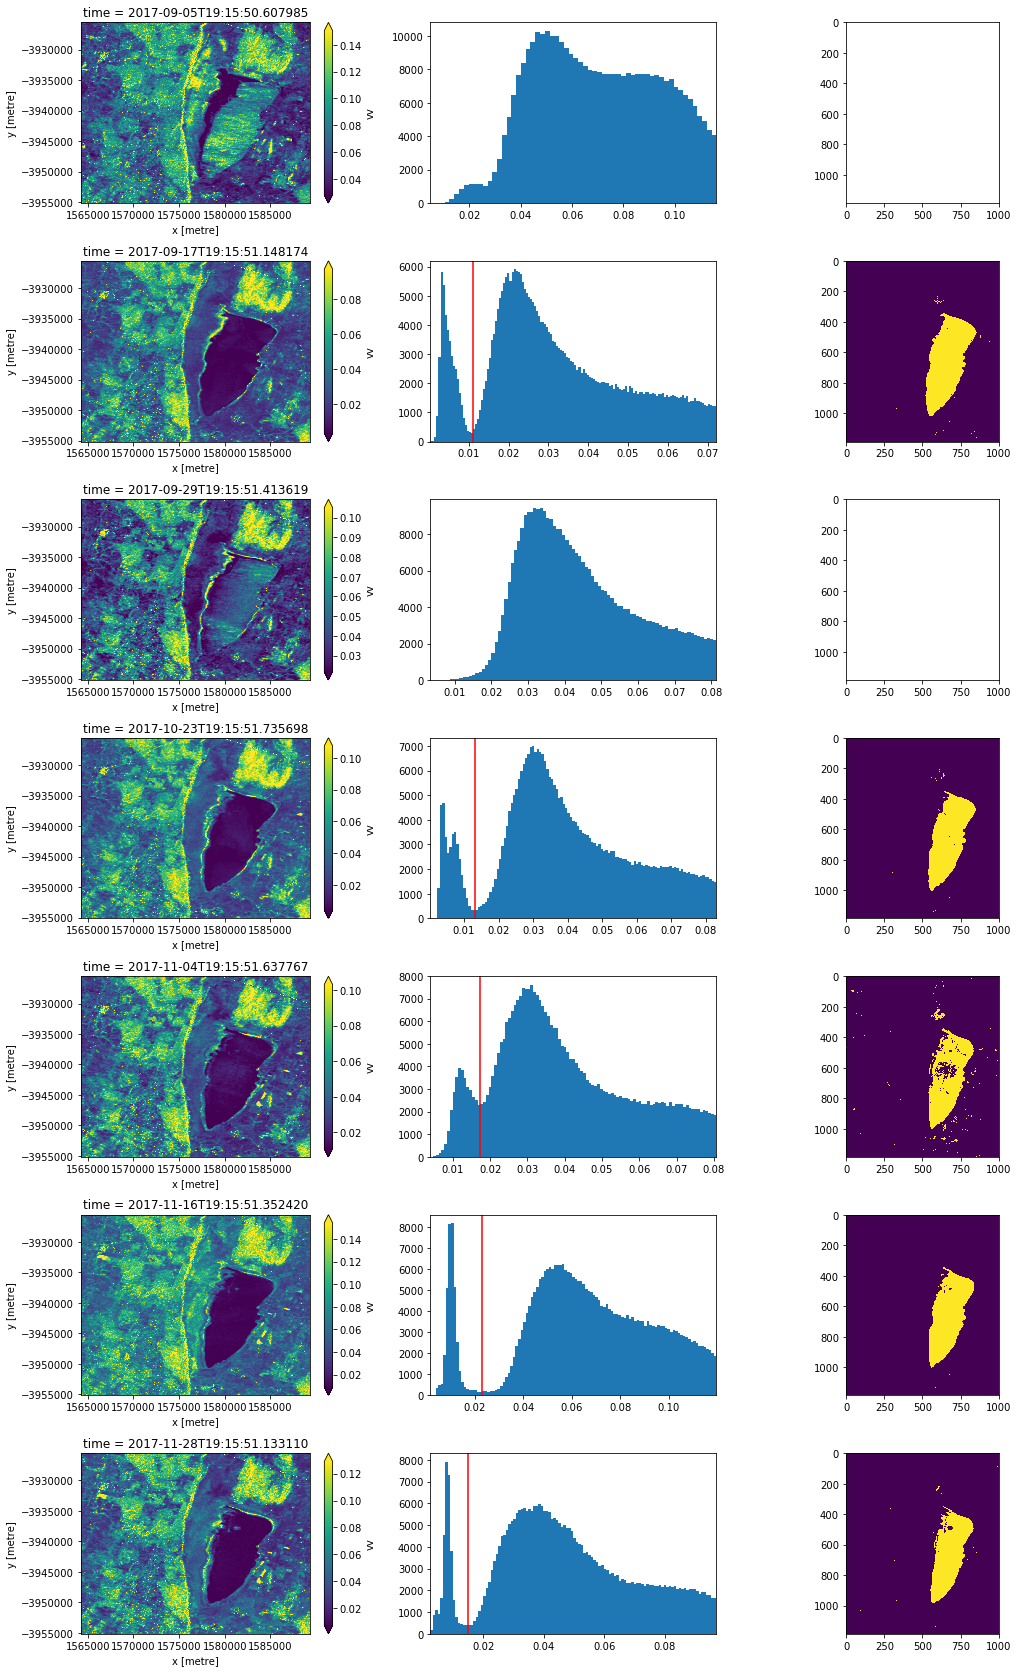

In [19]:
ntime = len(clean.time.values)
ncol = 3
nrow = int(np.ceil(ntime*3./ncol))

f=plt.figure(figsize=(15,10/ncol*nrow))
gs=GridSpec(nrow, ncol)

band = 'vv'
water = np.zeros_like(clean[band])

for i in range(ntime):
    ax = f.add_subplot(gs[i*3])
    clean[band].isel(time=i).plot.imshow(ax= ax, robust=True)
    
    ax = f.add_subplot(gs[i*3+1])
    arr = clean[band].isel(time=i).values.ravel()
    arr = arr[~np.isnan(arr)]
    # shorten the array to speed up
    arr = arr[arr < np.percentile(arr, 90)]
    hist, hist_x = histogram(np.random.choice(arr, int(len(arr)/3)), bins='knuth')
    ax.bar(hist_x[:-1],hist,width=hist_x[1]-hist_x[0], align='edge')
    ax.set_xlim((hist_x[0],hist_x[-1]))
    
    minima= find_optimal_minimum(hist, hist_x, min_valid=0.001, max_valid=0.03, min_contrast=1.2, min_perc= 0.01)

    if minima is not None:
        water[i,:,:]=clean[band].isel(time=i) <= minima
        ax.axvline(minima, color='r')
    else: # failed to separate water and non-water, but can't say for sure there's no water
        water[i,:,:] = np.nan
    
    ax = f.add_subplot(gs[i*3+2])
    ax.imshow(water[i,::-1,::-1]) # orientation consistent with xarray plot

f.tight_layout()

In [20]:
# add water classification into xarray
clean['water'] = ('time','y','x'), water
clean['water'] = clean.water.where(~clean.vv.isnull())

## 5. Calculate water detection frequencies and compare to optical detections <a name="summary"></a>

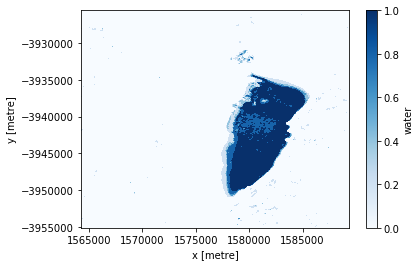

In [21]:
# detection frequency 
s1_water_freq = clean.water.mean(dim='time')
s1_water_freq.plot(cmap='Blues')

In [22]:
# load Water Observation from Space classifications from Digital Earth Australia

from digitalearthau.utils import wofs_fuser

prod_dc = datacube.Datacube()
wofs = prod_dc.load(product='wofs_albers', group_by='solar_day', fuse_func=wofs_fuser, **query)

# Only include clear detections
clear = np.isin(wofs.water, [0,128])
wofs_clear = (wofs==128).where(clear)
wofs_freq = wofs_clear.water.mean(dim='time')

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


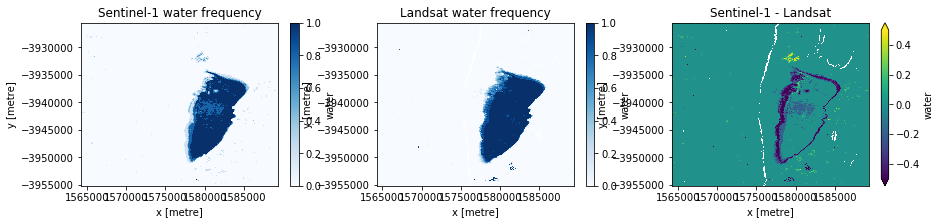

In [23]:
f, axes = plt.subplots(1,3, figsize=(15,3))

s1_water_freq.plot(cmap='Blues', ax = axes[0])
axes[0].set_title('Sentinel-1 water frequency');

wofs_freq.plot(cmap='Blues', ax = axes[1])
axes[1].set_title('Landsat water frequency');

# difference between S1 and Landsat wofs
(s1_water_freq-wofs_freq).plot(vmin=-0.5, vmax=0.5, ax = axes[2])
axes[2].set_title('Sentinel-1 - Landsat');

# lake edge is consitenly missed by Sentinel-1 due to high backscatter

In [24]:
# Save output to file
import os
outputfile = 's1_water.nc'
if os.path.exists(outputfile): os.remove(outputfile)
water = clean.water.to_dataset(name='water')
dataset_to_output =  water.assign_attrs(radar.attrs)
datacube.drivers.netcdf.write_dataset_to_netcdf(dataset_to_output, outputfile)